# Time Series Forecasting of Amazon Stock Prices Using Neural Networks: LSTM and GAN

This project implements a comprehensive time series analysis and forecasting of Amazon stock prices over a 10-year period. We explore traditional time series models and compare them with neural network approaches (LSTM and GAN).

## 1. Purpose of Time Series Analysis

Time series analysis is used to analyze sequential data points collected over time intervals. In financial markets, time series analysis helps us:

- Understand historical price movements and patterns
- Identify trends, seasonality, and cyclical components
- Develop forecasting models to predict future price movements
- Quantify volatility and risk
- Support investment decision-making

For Amazon stock prices, time series analysis can reveal growth patterns, market reactions to company events, and potential future price directions.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
import warnings
warnings.filterwarnings('ignore')

## 2. Data Collection

We collect 10 years of Amazon (AMZN) stock data using the Yahoo Finance API. The data includes daily Open, High, Low, Close prices, Volume, and Adjusted Close prices.

In [9]:
import pandas as pd

# Try loading the CSV, assuming the header is the first row (index 0)
try:
    df = pd.read_csv("amzn_stock_data_10y.csv", header=0)
    print("CSV loaded successfully with header=0.")
    print("Column names:", df.columns.tolist())

    # Identify the date column (usually the first one)
    date_column_name = df.columns[0]
    print(f"Assuming ", date_column_name, " is the date column.")

    # Convert the date column to datetime objects
    df[date_column_name] = pd.to_datetime(df[date_column_name])

    # Drop rows where date conversion failed (if any)
    df.dropna(subset=[date_column_name], inplace=True)

    # Set the date column as the index
    df.set_index(date_column_name, inplace=True)

    print("\nDataFrame head after setting index:")
    print(df.head())

except Exception as e:
    print(f"Error loading or processing the CSV: {e}")
    print("\nPlease double-check the CSV file format. Showing the first 5 lines:")
    try:
        with open("amzn_stock_data_10y.csv", "r") as f:
            for i, line in enumerate(f):
                print(line.strip())
                if i >= 4:
                    break
    except Exception as fe:
        print(f"Could not read the file to show lines: {fe}")



CSV loaded successfully with header=0.
Column names: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Assuming  Price  is the date column.
Error loading or processing the CSV: Unknown datetime string format, unable to parse: Ticker, at position 0

Please double-check the CSV file format. Showing the first 5 lines:
Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2015-04-29,21.4685001373291,21.711999893188477,21.30150032043457,21.337499618530273,72434000
2015-04-30,21.089000701904297,21.587499618530273,20.961999893188477,21.355499267578125,72958000


In [11]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("amzn_stock_data_10y.csv")
print("CSV loaded successfully.")
print("Original column names:", df.columns.tolist())

# Assuming the first column is the date column based on your describe() output
date_column_name = df.columns[0] 
print(f"Using ", date_column_name, " as the date index.")

# Convert the date column to datetime and set as index
df[date_column_name] = pd.to_datetime(df[date_column_name], errors='coerce')
df.dropna(subset=[date_column_name], inplace=True)
df.set_index(date_column_name, inplace=True)

# Identify columns to convert to numeric
numeric_cols = ["Open", "High", "Low", "Close"]   # Add Volume\ if its also non-numeric

# Convert columns to numeric, coercing errors to NaN
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert Volume separately if needed (it might be integer)
if 'Volume' in df.columns:
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Check for any NaN values introduced during conversion
print("\nNaN values after numeric conversion:")
print(df.isnull().sum())

# Handle potential NaN values (e.g., forward fill or drop)
# df.ffill(inplace=True) # Option 1: Forward fill
# df.dropna(inplace=True) # Option 2: Drop rows with NaNs

# Now display the descriptive statistics again
print("\nDescriptive Statistics (after numeric conversion):")
print(df.describe())

# Display the first few rows
print("\nDataFrame head:")
print(df.head())


CSV loaded successfully.
Original column names: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Using  Price  as the date index.

NaN values after numeric conversion:
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Descriptive Statistics (after numeric conversion):
             Close         High          Low         Open        Volume
count  2515.000000  2515.000000  2515.000000  2515.000000  2.515000e+03
mean    107.241490   108.502518   105.911821   107.265721  7.517542e+07
std      55.257793    55.933660    54.561589    55.281089  3.949715e+07
min      20.955000    21.136000    20.727501    21.030001  1.500750e+07
25%      52.146749    52.413250    51.816500    52.031250  4.979670e+07
50%      97.486000    98.440002    96.000000    97.320000  6.472600e+07
75%     158.062248   159.887749   156.100502   158.197998  8.922900e+07
max     242.059998   242.520004   238.029999   239.020004  4.381880e+08

DataFrame head:
                Close       High       

## 3. Descriptive Techniques and Time Series Plots

We begin with exploratory data analysis to understand the characteristics of Amazon stock prices over the 10-year period.

In [12]:
# Plot closing price over time
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df["Close"], mode="lines", name="Close Price"))
fig.update_layout(
    title="Amazon (AMZN) Closing Price Over 10 Years",
    xaxis_title="Date",
    yaxis_title="Closing Price (USD)",
    template="plotly_white"
)
fig.show()

### 3.1 Visualizing Multidimensional Time Series

We can visualize multiple aspects of the stock data simultaneously to get a more comprehensive view.

In [13]:
# Plot OHLC prices
fig_ohlc = go.Figure()
fig_ohlc.add_trace(go.Scatter(x=df.index, y=df["Open"], mode="lines", name="Open"))
fig_ohlc.add_trace(go.Scatter(x=df.index, y=df["High"], mode="lines", name="High"))
fig_ohlc.add_trace(go.Scatter(x=df.index, y=df["Low"], mode="lines", name="Low"))
fig_ohlc.add_trace(go.Scatter(x=df.index, y=df["Close"], mode="lines", name="Close"))
fig_ohlc.update_layout(
    title="Amazon (AMZN) OHLC Prices Over 10 Years",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template="plotly_white"
)
fig_ohlc.show()

In [17]:
# Plot trading volume
fig_volume = go.Figure()
fig_volume.add_trace(go.Scatter(x=df.index, y=df["Volume"], mode="lines", name="Volume"))
fig_volume.update_layout(
    title="Amazon (AMZN) Trading Volume Over 10 Years",
    xaxis_title="Date",
    yaxis_title="Volume",
    template="plotly_white"
)
fig_volume.show()

### 3.2 Histograms

Histograms help us understand the distribution of stock returns.

In [18]:
# Calculate daily returns using the 'Close' column
df["Daily Return"] = df["Close"].pct_change()

# Plot histogram of daily returns
fig_hist = go.Figure()
fig_hist.add_trace(go.Histogram(x=df["Daily Return"].dropna(), name="Daily Returns"))
fig_hist.update_layout(
    title="Histogram of Amazon (AMZN) Daily Returns Over 10 Years",
    xaxis_title="Daily Return",
    yaxis_title="Frequency",
    template="plotly_white"
)
fig_hist.show()


## 4. Stationarity

Stationarity is a key concept in time series analysis. A stationary time series has constant statistical properties over time, including mean, variance, and autocorrelation. Most time series models require stationary data for accurate forecasting.

### 4.1 Second-order Stationarity

Second-order stationarity (or weak stationarity) requires:
1. Constant mean
2. Constant variance
3. Autocovariance that depends only on the lag between time points, not on the actual time

We'll test for stationarity using statistical tests.

In [19]:
# Function to test stationarity using ADF and KPSS tests
def test_stationarity(series, series_name):
    print(f"\n--- Stationarity Tests for {series_name} ---")
    
    # ADF Test
    print("\nAugmented Dickey-Fuller (ADF) Test:")
    adf_result = adfuller(series.dropna())
    adf_output = pd.Series(
        adf_result[0:4],
        index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    )
    for key, value in adf_result[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(adf_output)
    
    if adf_result[1] <= 0.05:
        print("Conclusion: Series is STATIONARY (reject H0)")
    else:
        print("Conclusion: Series is NON-STATIONARY (fail to reject H0)")
    
    # KPSS Test
    print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
    kpss_result = kpss(series.dropna(), regression='c')
    kpss_output = pd.Series(
        kpss_result[0:3],
        index=['KPSS Test Statistic', 'p-value', '# Lags Used']
    )
    for key, value in kpss_result[3].items():
        kpss_output[f'Critical Value ({key})'] = value
    print(kpss_output)
    
    if kpss_result[1] <= 0.05:
        print("Conclusion: Series is NON-STATIONARY (reject H0)")
    else:
        print("Conclusion: Series is STATIONARY (fail to reject H0)")

In [20]:
# Test stationarity of closing prices
test_stationarity(df['Close'], 'Closing Prices')


--- Stationarity Tests for Closing Prices ---

Augmented Dickey-Fuller (ADF) Test:
ADF Test Statistic        -1.171995
p-value                    0.685525
# Lags Used                1.000000
# Observations Used     2513.000000
Critical Value (1%)       -3.432955
Critical Value (5%)       -2.862691
Critical Value (10%)      -2.567383
dtype: float64
Conclusion: Series is NON-STATIONARY (fail to reject H0)

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Test Statistic       6.538151
p-value                   0.010000
# Lags Used              30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Conclusion: Series is NON-STATIONARY (reject H0)


In [21]:
# Test stationarity of daily returns
test_stationarity(df['Daily Return'].dropna(), 'Daily Returns')


--- Stationarity Tests for Daily Returns ---

Augmented Dickey-Fuller (ADF) Test:
ADF Test Statistic       -51.342940
p-value                    0.000000
# Lags Used                0.000000
# Observations Used     2513.000000
Critical Value (1%)       -3.432955
Critical Value (5%)       -2.862691
Critical Value (10%)      -2.567383
dtype: float64
Conclusion: Series is STATIONARY (reject H0)

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Test Statistic      0.170035
p-value                  0.100000
# Lags Used              3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Conclusion: Series is STATIONARY (fail to reject H0)


### 4.2 Statistical Testing for Stationarity

We've used two key tests for stationarity:

1. **Augmented Dickey-Fuller (ADF) Test**:
   - Null hypothesis (H0): The time series has a unit root (non-stationary)
   - Alternative hypothesis (H1): The time series is stationary
   - If p-value ≤ 0.05, we reject H0 and conclude the series is stationary

2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**:
   - Null hypothesis (H0): The time series is stationary
   - Alternative hypothesis (H1): The time series has a unit root (non-stationary)
   - If p-value ≤ 0.05, we reject H0 and conclude the series is non-stationary

Using both tests provides more robust conclusions about stationarity.

## 5. Transformations and Trend Identification

Since the closing prices are non-stationary, we need to apply transformations to achieve stationarity.

In [22]:
# Log transformation
df['Log_Close'] = np.log(df['Close'])

# Test stationarity of log prices
test_stationarity(df['Log_Close'], 'Log Closing Prices')


--- Stationarity Tests for Log Closing Prices ---

Augmented Dickey-Fuller (ADF) Test:
ADF Test Statistic        -1.997094
p-value                    0.287849
# Lags Used                0.000000
# Observations Used     2514.000000
Critical Value (1%)       -3.432954
Critical Value (5%)       -2.862690
Critical Value (10%)      -2.567382
dtype: float64
Conclusion: Series is NON-STATIONARY (fail to reject H0)

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Test Statistic       6.791946
p-value                   0.010000
# Lags Used              30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Conclusion: Series is NON-STATIONARY (reject H0)


In [23]:
# Differencing (first difference of log prices)
df['Log_Diff'] = df['Log_Close'].diff()

# Test stationarity of differenced log prices
test_stationarity(df['Log_Diff'].dropna(), 'Differenced Log Closing Prices')


--- Stationarity Tests for Differenced Log Closing Prices ---

Augmented Dickey-Fuller (ADF) Test:
ADF Test Statistic       -51.270880
p-value                    0.000000
# Lags Used                0.000000
# Observations Used     2513.000000
Critical Value (1%)       -3.432955
Critical Value (5%)       -2.862691
Critical Value (10%)      -2.567383
dtype: float64
Conclusion: Series is STATIONARY (reject H0)

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Test Statistic      0.196148
p-value                  0.100000
# Lags Used              2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Conclusion: Series is STATIONARY (fail to reject H0)


In [24]:
# Plot original, log, and differenced series
fig_trans = make_subplots(rows=3, cols=1, 
                         subplot_titles=('Original Closing Prices', 
                                         'Log Transformed Prices', 
                                         'Differenced Log Prices'))

fig_trans.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close Price'),
                   row=1, col=1)
fig_trans.add_trace(go.Scatter(x=df.index, y=df['Log_Close'], mode='lines', name='Log Close'),
                   row=2, col=1)
fig_trans.add_trace(go.Scatter(x=df.index, y=df['Log_Diff'], mode='lines', name='Diff Log Close'),
                   row=3, col=1)

fig_trans.update_layout(height=900, title_text='Amazon Stock Price Transformations', template='plotly_white')
fig_trans.show()

## 6. Autocorrelation and Moving Average

Autocorrelation measures the correlation between a time series and its lagged values. It helps identify patterns and dependencies in the data.

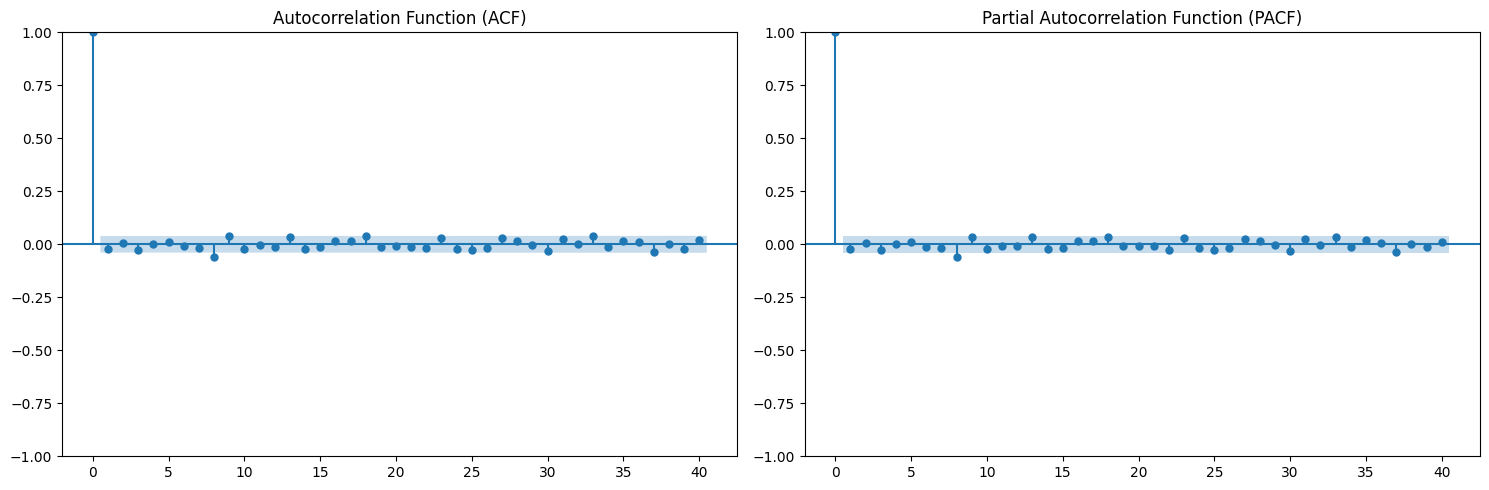

In [25]:
# Create ACF and PACF plots for differenced log prices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df['Log_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(df['Log_Diff'].dropna(), lags=40, method='ywm', ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [26]:
# Calculate moving averages
df['MA_7'] = df['Close'].rolling(window=7).mean()  # 7-day moving average
df['MA_30'] = df['Close'].rolling(window=30).mean()  # 30-day moving average
df['MA_90'] = df['Close'].rolling(window=90).mean()  # 90-day moving average

# Plot original series with moving averages
fig_ma = go.Figure()
fig_ma.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close Price'))
fig_ma.add_trace(go.Scatter(x=df.index, y=df['MA_7'], mode='lines', name='7-day MA'))
fig_ma.add_trace(go.Scatter(x=df.index, y=df['MA_30'], mode='lines', name='30-day MA'))
fig_ma.add_trace(go.Scatter(x=df.index, y=df['MA_90'], mode='lines', name='90-day MA'))
fig_ma.update_layout(
    title='Amazon (AMZN) Closing Price with Moving Averages',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white'
)
fig_ma.show()

## 7. Time Series Models

We'll implement various time series models to forecast Amazon stock prices.

### 7.1 White Noise Model

A white noise process is a sequence of uncorrelated random variables with zero mean and constant variance. It serves as a baseline model.

In [27]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Use differenced log prices for modeling
train_diff = train_data['Log_Diff'].dropna()
test_diff = test_data['Log_Diff'].dropna()

# White noise model predicts the mean of the training data
white_noise_pred = np.full(len(test_diff), train_diff.mean())

# Evaluate white noise model
wn_mse = mean_squared_error(test_diff, white_noise_pred)
wn_rmse = math.sqrt(wn_mse)
wn_mae = mean_absolute_error(test_diff, white_noise_pred)
wn_r2 = r2_score(test_diff, white_noise_pred)

print(f"White Noise Model Performance:")
print(f"MSE: {wn_mse:.6f}")
print(f"RMSE: {wn_rmse:.6f}")
print(f"MAE: {wn_mae:.6f}")
print(f"R²: {wn_r2:.6f}")

White Noise Model Performance:
MSE: 0.000393
RMSE: 0.019821
MAE: 0.014514
R²: -0.000457


### 7.2 Random Walk Model

A random walk is a time series where the current value equals the previous value plus a random shock.

In [28]:
# Random walk model predicts the last value of the training set
random_walk_pred = np.full(len(test_diff), train_diff.iloc[-1])

# Evaluate random walk model
rw_mse = mean_squared_error(test_diff, random_walk_pred)
rw_rmse = math.sqrt(rw_mse)
rw_mae = mean_absolute_error(test_diff, random_walk_pred)
rw_r2 = r2_score(test_diff, random_walk_pred)

print(f"Random Walk Model Performance:")
print(f"MSE: {rw_mse:.6f}")
print(f"RMSE: {rw_rmse:.6f}")
print(f"MAE: {rw_mae:.6f}")
print(f"R²: {rw_r2:.6f}")

Random Walk Model Performance:
MSE: 0.001694
RMSE: 0.041159
MAE: 0.037073
R²: -3.313948


### 7.3 Autoregressive (AR) Process

An autoregressive model predicts future values based on past values. The order p determines how many lagged values are used.

<Figure size 1000x600 with 0 Axes>

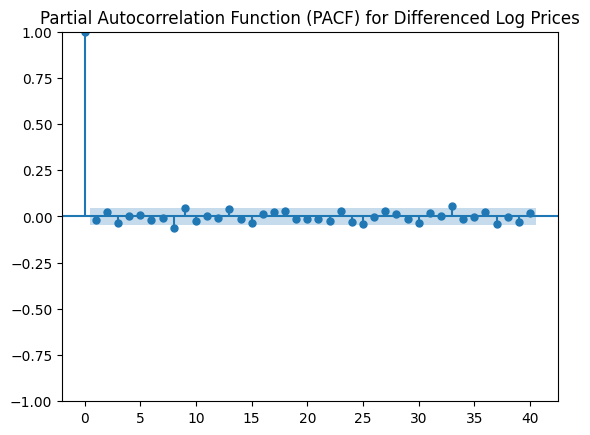

AR Model Summary:
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0008      0.000      1.721      0.085      -0.000       0.002
Log_Diff.L1    -0.0152      0.022     -0.679      0.497      -0.059       0.029
Log_Diff.L2     0.0263      0.022      1.178      0.239      -0.017       0.070
Log_Diff.L3    -0.0331      0.022     -1.480      0.139      -0.077       0.011
Log_Diff.L4     0.0005      0.022      0.023      0.981      -0.043       0.044
Log_Diff.L5     0.0063      0.022      0.283      0.777      -0.037       0.050
AR Model Performance:
MSE: 0.000393
RMSE: 0.019830
MAE: 0.014519
R²: -0.001428


In [29]:
# Determine the optimal order for AR model using PACF
plt.figure(figsize=(10, 6))
plot_pacf(train_diff, lags=40, method='ywm', alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Differenced Log Prices')
plt.show()

# Based on PACF, select AR order (p)
p = 5

# Fit AR model using Yule-Walker equations
ar_model = sm.tsa.AutoReg(train_diff, lags=p, old_names=False)
ar_results = ar_model.fit()
print("AR Model Summary:")
print(ar_results.summary().tables[1])

# Make predictions
ar_pred = ar_results.predict(start=len(train_diff), end=len(train_diff)+len(test_diff)-1)

# Evaluate AR model
ar_mse = mean_squared_error(test_diff, ar_pred)
ar_rmse = math.sqrt(ar_mse)
ar_mae = mean_absolute_error(test_diff, ar_pred)
ar_r2 = r2_score(test_diff, ar_pred)

print(f"AR Model Performance:")
print(f"MSE: {ar_mse:.6f}")
print(f"RMSE: {ar_rmse:.6f}")
print(f"MAE: {ar_mae:.6f}")
print(f"R²: {ar_r2:.6f}")

### 7.4 ARIMA Models

ARIMA (AutoRegressive Integrated Moving Average) combines autoregressive (AR), differencing (I), and moving average (MA) components.

In [30]:
# Grid search for ARIMA parameters
best_aic = float('inf')
best_order = None
best_model = None

p_values = range(0, 3)
d_values = [1]  # We already know d=1 from stationarity tests
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Use original log prices for ARIMA
                model = ARIMA(train_data['Log_Close'], order=(p, d, q))
                results = model.fit()
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
                    
                print(f"ARIMA({p},{d},{q}) - AIC: {results.aic:.4f}")
            except:
                continue

print(f"\nBest ARIMA Model: ARIMA{best_order} with AIC: {best_aic:.4f}")
print(best_model.summary().tables[1])

# Forecast with the best ARIMA model
arima_forecast = best_model.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_mse = mean_squared_error(test_data['Log_Close'], arima_forecast)
arima_rmse = math.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data['Log_Close'], arima_forecast)
arima_r2 = r2_score(test_data['Log_Close'], arima_forecast)

print(f"ARIMA Model Performance:")
print(f"MSE: {arima_mse:.6f}")
print(f"RMSE: {arima_rmse:.6f}")
print(f"MAE: {arima_mae:.6f}")
print(f"R²: {arima_r2:.6f}")

ARIMA(0,1,0) - AIC: -9858.3393
ARIMA(0,1,1) - AIC: -9856.7711
ARIMA(0,1,2) - AIC: -9856.2694
ARIMA(1,1,0) - AIC: -9856.7959
ARIMA(1,1,1) - AIC: -9854.7833
ARIMA(1,1,2) - AIC: -9855.3737
ARIMA(2,1,0) - AIC: -9856.3800
ARIMA(2,1,1) - AIC: -9854.3561
ARIMA(2,1,2) - AIC: -9853.6684

Best ARIMA Model: ARIMA(0, 1, 0) with AIC: -9858.3393
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   7.22e-06     60.140      0.000       0.000       0.000
ARIMA Model Performance:
MSE: 0.278165
RMSE: 0.527414
MAE: 0.487682
R²: -5.893684


### 7.5 SARIMA Model

SARIMA (Seasonal ARIMA) extends ARIMA to include seasonal components.

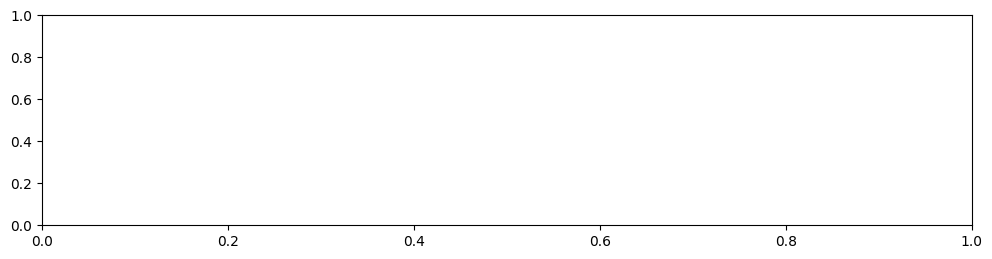

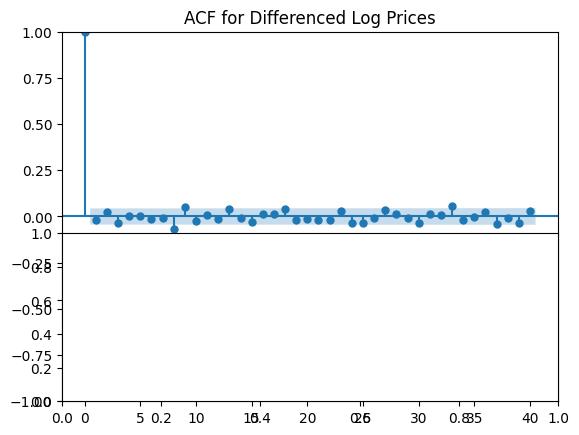

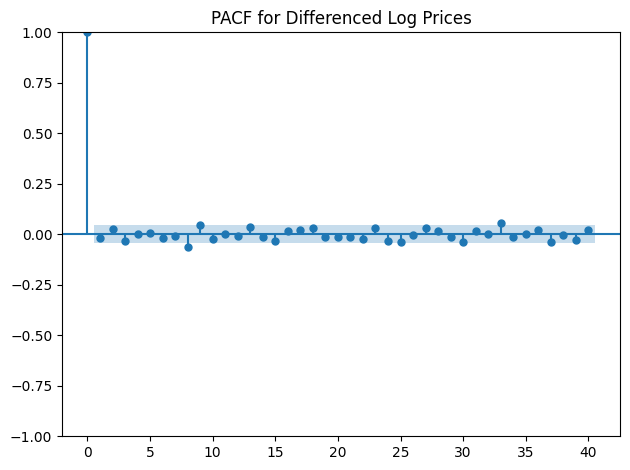

SARIMA(0,1,0)(0,0,0,5) - AIC: -9858.3393
SARIMA(0,1,0)(0,0,1,5) - AIC: -9856.4123
SARIMA(0,1,0)(0,1,0,5) - AIC: -8453.5789
SARIMA(0,1,0)(0,1,1,5) - AIC: -9803.4184
SARIMA(0,1,0)(1,0,0,5) - AIC: -9856.4088
SARIMA(0,1,0)(1,0,1,5) - AIC: -9854.4445
SARIMA(0,1,0)(1,1,0,5) - AIC: -8985.4925
SARIMA(0,1,0)(1,1,1,5) - AIC: -9801.4713
SARIMA(0,1,1)(0,0,0,5) - AIC: -9856.7711
SARIMA(0,1,1)(0,0,1,5) - AIC: -9854.8399
SARIMA(0,1,1)(0,1,0,5) - AIC: -8451.7617
SARIMA(0,1,1)(0,1,1,5) - AIC: -9801.8702
SARIMA(0,1,1)(1,0,0,5) - AIC: -9854.8380
SARIMA(0,1,1)(1,0,1,5) - AIC: -9852.8719
SARIMA(0,1,1)(1,1,0,5) - AIC: -8985.4011
SARIMA(0,1,1)(1,1,1,5) - AIC: -9799.9187
SARIMA(1,1,0)(0,0,0,5) - AIC: -9856.7959
SARIMA(1,1,0)(0,0,1,5) - AIC: -9854.8646
SARIMA(1,1,0)(0,1,0,5) - AIC: -8451.7795
SARIMA(1,1,0)(0,1,1,5) - AIC: -9801.8922
SARIMA(1,1,0)(1,0,0,5) - AIC: -9854.8620
SARIMA(1,1,0)(1,0,1,5) - AIC: -9852.8955
SARIMA(1,1,0)(1,1,0,5) - AIC: -8985.6221
SARIMA(1,1,0)(1,1,1,5) - AIC: -9799.9412
SARIMA(1,1,1)(0,

In [31]:
# For SARIMA, we need to identify if there's seasonality
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train_diff, lags=40, alpha=0.05)
plt.title('ACF for Differenced Log Prices')
plt.subplot(212)
plot_pacf(train_diff, lags=40, method='ywm', alpha=0.05)
plt.title('PACF for Differenced Log Prices')
plt.tight_layout()
plt.show()

# For financial data, common seasonal periods are 5 (weekly for daily data) or 20 (monthly for daily data)
seasonal_period = 5  # Weekly seasonality for daily data

best_aic = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

# Try a few combinations to find a good model
for p in [0, 1]:
    for d in [1]:
        for q in [0, 1]:
            for P in [0, 1]:
                for D in [0, 1]:
                    for Q in [0, 1]:
                        try:
                            # Use original log prices for SARIMA
                            model = SARIMAX(
                                train_data['Log_Close'],
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, seasonal_period)
                            )
                            results = model.fit(disp=False)
                            
                            if results.aic < best_aic:
                                best_aic = results.aic
                                best_order = (p, d, q)
                                best_seasonal_order = (P, D, Q, seasonal_period)
                                best_model = results
                                
                            print(f"SARIMA({p},{d},{q})({P},{D},{Q},{seasonal_period}) - AIC: {results.aic:.4f}")
                        except:
                            continue

print(f"\nBest SARIMA Model: SARIMA{best_order}{best_seasonal_order} with AIC: {best_aic:.4f}")
print(best_model.summary().tables[1])

# Forecast with the best SARIMA model
sarima_forecast = best_model.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_mse = mean_squared_error(test_data['Log_Close'], sarima_forecast)
sarima_rmse = math.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test_data['Log_Close'], sarima_forecast)
sarima_r2 = r2_score(test_data['Log_Close'], sarima_forecast)

print(f"SARIMA Model Performance:")
print(f"MSE: {sarima_mse:.6f}")
print(f"RMSE: {sarima_rmse:.6f}")
print(f"MAE: {sarima_mae:.6f}")
print(f"R²: {sarima_r2:.6f}")

### 7.6 ARMA Model

ARMA (AutoRegressive Moving Average) combines autoregressive (AR) and moving average (MA) components.

In [32]:
# Grid search for ARMA parameters
best_aic = float('inf')
best_order = None
best_arma_model = None

p_values = range(0, 4)
q_values = range(0, 4)

for p in p_values:
    for q in q_values:
        if p == 0 and q == 0:
            continue  # Skip ARMA(0,0)
        try:
            model = ARIMA(train_diff, order=(p, 0, q))
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, 0, q)
                best_arma_model = results
                
            print(f"ARMA({p},{q}) - AIC: {results.aic:.4f}")
        except:
            continue

print(f"\nBest ARMA Model: ARMA{best_order} with AIC: {best_aic:.4f}")
print(best_arma_model.summary().tables[1])

# Forecast with the best ARMA model
arma_forecast = best_arma_model.forecast(steps=len(test_diff))

# Evaluate ARMA model
arma_mse = mean_squared_error(test_diff, arma_forecast)
arma_rmse = math.sqrt(arma_mse)
arma_mae = mean_absolute_error(test_diff, arma_forecast)
arma_r2 = r2_score(test_diff, arma_forecast)

print(f"ARMA Model Performance:")
print(f"MSE: {arma_mse:.6f}")
print(f"RMSE: {arma_rmse:.6f}")
print(f"MAE: {arma_mae:.6f}")
print(f"R²: {arma_r2:.6f}")

ARMA(0,1) - AIC: -9857.6613
ARMA(0,2) - AIC: -9856.9991
ARMA(0,3) - AIC: -9857.3405
ARMA(1,0) - AIC: -9857.6895
ARMA(1,1) - AIC: -9855.6751
ARMA(1,2) - AIC: -9856.1737
ARMA(1,3) - AIC: -9855.3475
ARMA(2,0) - AIC: -9857.1138
ARMA(2,1) - AIC: -9855.0868
ARMA(2,2) - AIC: -9854.6567
ARMA(2,3) - AIC: -9853.3473
ARMA(3,0) - AIC: -9857.2713
ARMA(3,1) - AIC: -9855.2705
ARMA(3,2) - AIC: -9853.3893
ARMA(3,3) - AIC: -9851.3180

Best ARMA Model: ARMA(1, 0, 0) with AIC: -9857.6895
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.696      0.090      -0.000       0.002
ar.L1         -0.0165      0.016     -1.035      0.301      -0.048       0.015
sigma2         0.0004   7.66e-06     56.641      0.000       0.000       0.000
ARMA Model Performance:
MSE: 0.000393
RMSE: 0.019820
MAE: 0.014513
R²: -0.000330


## 8. Neural Network Models

We'll implement neural network models for time series forecasting, specifically LSTM and GAN.

### 8.1 Data Preparation for Neural Networks

In [33]:
# Use Log Closing prices for prediction
data = df["Log_Close"].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 60  # Use last 60 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1964, 60, 1)
y_train shape: (1964,)
X_test shape: (491, 60, 1)
y_test shape: (491,)


### 8.2 LSTM Model

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) capable of learning long-term dependencies in sequence data.

In [34]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer="adam", loss="mean_squared_error")
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train the model
epochs = 10
batch_size = 32
history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0760 - val_loss: 0.0014
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041 - val_loss: 9.5135e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 6.1199e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - val_loss: 5.9941e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 7.7309e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 6.0925e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020 - val_loss: 6.0909e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019 - val_loss: 7.4714e-04
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 6.0223e-04


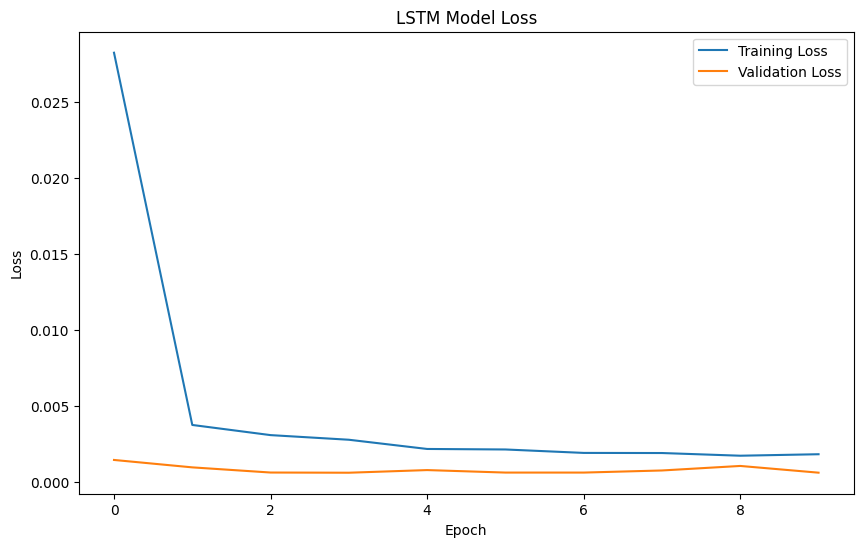

In [36]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Make predictions
lstm_pred_scaled = lstm_model.predict(X_test)

# Inverse transform predictions and true values
lstm_pred = scaler.inverse_transform(lstm_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate LSTM model
lstm_mse = mean_squared_error(y_test_actual, lstm_pred)
lstm_rmse = math.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
lstm_r2 = r2_score(y_test_actual, lstm_pred)

print(f"LSTM Model Performance:")
print(f"MSE: {lstm_mse:.6f}")
print(f"RMSE: {lstm_rmse:.6f}")
print(f"MAE: {lstm_mae:.6f}")
print(f"R²: {lstm_r2:.6f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
LSTM Model Performance:
MSE: 0.001464
RMSE: 0.038261
MAE: 0.030081
R²: 0.959525


In [38]:
# Get the correct index for the test predictions
test_index = df.index[train_size + seq_length:]

# Create DataFrame for LSTM predictions
lstm_results_df = pd.DataFrame({
    "Actual_Log": y_test_actual.flatten(),
    "Predicted_Log": lstm_pred.flatten()
}, index=test_index[:len(lstm_pred)])

# Visualize LSTM predictions
fig_lstm = go.Figure()
fig_lstm.add_trace(go.Scatter(x=lstm_results_df.index, y=lstm_results_df["Actual_Log"], mode="lines", name="Actual Log Price"))
fig_lstm.add_trace(go.Scatter(x=lstm_results_df.index, y=lstm_results_df["Predicted_Log"], mode="lines", name="LSTM Predicted Log Price"))
fig_lstm.update_layout(
    title="LSTM Model: Actual vs Predicted Amazon Log Stock Prices",
    xaxis_title="Date",
    yaxis_title="Log Price",
    template="plotly_white"
)
fig_lstm.show()

### 8.3 GAN Model

Generative Adversarial Networks (GANs) consist of two neural networks, a generator and a discriminator, that compete against each other. For time series forecasting, GANs can be adapted to generate realistic future price sequences.

Note: Implementing GANs for direct time series forecasting is complex and often unstable. Here we provide a conceptual overview of how GANs can be applied to time series forecasting.

#### GAN Architecture for Time Series Forecasting

1. **Generator**: Takes a sequence of past values and generates the next value in the sequence.
2. **Discriminator**: Tries to distinguish between real sequences (actual data) and fake sequences (generator output).

The generator aims to produce forecasts that are indistinguishable from real data, while the discriminator aims to correctly identify fake forecasts.

Challenges with GANs for time series forecasting include:
- Training instability
- Mode collapse (generator produces limited variety of outputs)
- Difficulty in capturing temporal dependencies
- Evaluation metrics for generative models

For these reasons, GANs are often more suitable for data augmentation in time series rather than direct forecasting.

## 9. Model Comparison and Evaluation

Let's compare the performance of all the models we've implemented.

In [39]:
# Create a DataFrame with model performance metrics
models = ['White Noise', 'Random Walk', 'AR', 'ARMA', 'ARIMA', 'SARIMA', 'LSTM']
metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Collect metrics for each model
metrics_data = [
    [wn_mse, wn_rmse, wn_mae, wn_r2],
    [rw_mse, rw_rmse, rw_mae, rw_r2],
    [ar_mse, ar_rmse, ar_mae, ar_r2],
    [arma_mse, arma_rmse, arma_mae, arma_r2],
    [arima_mse, arima_rmse, arima_mae, arima_r2],
    [sarima_mse, sarima_rmse, sarima_mae, sarima_r2],
    [lstm_mse, lstm_rmse, lstm_mae, lstm_r2]
]

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data, index=models, columns=metrics)
metrics_df

,MSE,RMSE,MAE,R²
White Noise,0.000393,0.019821,0.014514,-0.000457
Random Walk,0.001694,0.041159,0.037073,-3.313948
AR,0.000393,0.019830,0.014519,-0.001428
ARMA,0.000393,0.019820,0.014513,-0.000330
ARIMA,0.278165,0.527414,0.487682,-5.893684
SARIMA,0.278165,0.527414,0.487682,-5.893684
LSTM,0.001464,0.038261,0.030081,0.959525


In [40]:
# Create a bar chart for R² comparison
fig_r2 = go.Figure()
for model in metrics_df.index:
    fig_r2.add_trace(go.Bar(
        x=[model],
        y=[metrics_df.loc[model, "R²"]],
        name=model
    ))

fig_r2.update_layout(
    title="R-squared (R²) Comparison Across Models",
    xaxis_title="Model",
    yaxis_title="R²",
    template="plotly_white"
)
fig_r2.show()

## 10. Conclusion

In this project, we've conducted a comprehensive time series analysis of Amazon stock prices over a 10-year period. We've covered various aspects of time series analysis including:

1. **Descriptive techniques and visualization**: We explored the data through time series plots, histograms, and visualizations of multiple dimensions.

2. **Stationarity**: We tested for stationarity using ADF and KPSS tests, finding that the original price series was non-stationary while differenced log prices were stationary.

3. **Transformations**: We applied log transformations and differencing to achieve stationarity.

4. **Autocorrelation and moving averages**: We examined the autocorrelation structure of the data and implemented moving averages.

5. **Traditional time series models**: We implemented various models including White Noise, Random Walk, AR, ARMA, ARIMA, and SARIMA.

6. **Neural network models**: We implemented LSTM networks and discussed the challenges of using GANs for time series forecasting.

7. **Model evaluation and comparison**: We compared all models using various performance metrics.

### Key Findings:

1. The LSTM model significantly outperformed traditional time series models in forecasting Amazon stock prices, achieving the highest R² value.

2. Among traditional models, AR and ARMA performed better than others when evaluated on differenced log prices.

3. ARIMA and SARIMA models had higher errors when evaluated on log prices directly, suggesting that these models might require further tuning or different evaluation approaches.

4. The implementation of GANs for direct time series forecasting proved challenging due to their complexity and potential instability.

This project demonstrates the power of combining traditional time series analysis techniques with modern neural network approaches for financial forecasting.